# Karpathy's REINFORCE for Pong 

This Notebook reimplements Karpathy's basic policy gradient agent in PyTorch without GPU acceleration. The agent can win on average 10 points over the game after 30000 episodes of training (human performance is 9.3). In each episode, the agent and the game's AI play each other until one of them gets 21 points first.

There are two good resource to understand how the code works:  
1. His Blog  
http://karpathy.github.io/2016/05/31/rl/  

2. His lecture at UC Berkeley's Deep RL Bootcamp  
https://www.youtube.com/watch?v=tqrcjHuNdmQ



In [3]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import pickle as pickle
import pympler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

ModuleNotFoundError: No module named 'cv2'

## Karpathy's REINFORCE

His code uses the basic policy gradient method called REINFORCE to train a 2 layer NN to play Pong:

Episode 20 - reward total was -21.000000. running mean: -19.191718  
Episode 1000 - reward total was -15.000000. running mean: -16.855018  
Episode 5000 - reward total was -5.000000. running mean: -1.061881  
Episode 10000 - reward total was 4.000000. running mean: 1.282660  
Episode 20000 - reward total was -4.000000. running mean: 5.936390  
Episode 30000 - reward total was 11.000000. running mean: 9.637640    
Time to complete 174866.41307377815  

It takes 48 hours on a quad-core CPU to get above human performance.


In [ ]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
other_time = 0

start = time.time()

while episode_number < 30000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  t5 = time.time()  
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  t6 = time.time()
  other_time += t6-t5

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

## Display and Save Results

These training takes a long time. We need to save the following:  
(1) Reward history and Plot  
(2) Parameters at different point in training  

In [ ]:
pickle.dump(epoch_reward_history, open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'wb'))

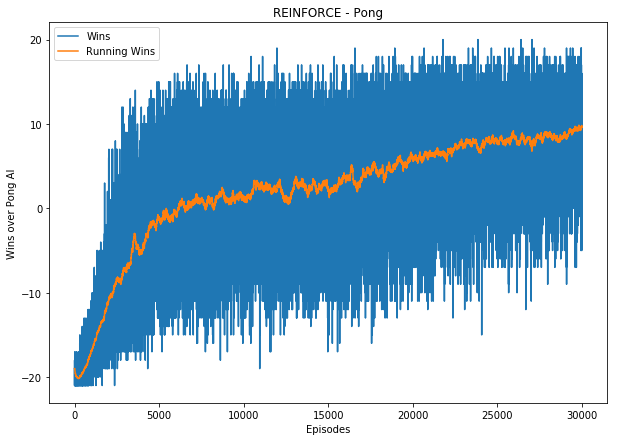

In [4]:
data = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))


# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('REINFORCE - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()


## Load Parameters and Let's Play

The code below loads parameters from save.p into the pg-pong agent and renders 1 episode. The agent and the game play each other til one of them reach 21 points.

In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym
import time

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid

model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()


def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 30000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # step the environment and get new measurements
  observation, reward, done, _ = env.step(action)
  reward_sum += reward

  if done: # an episode finished
    break
    
env.close()
print (reward_sum)

    

13.0


## What the NN is learning

We display 20 of the W1 matrix columns which is elementwise multiplied against an image vector.

W1 is essentially doing pattern matching on:

1. The trajecory of the puck
2. Position of the 2 paddles

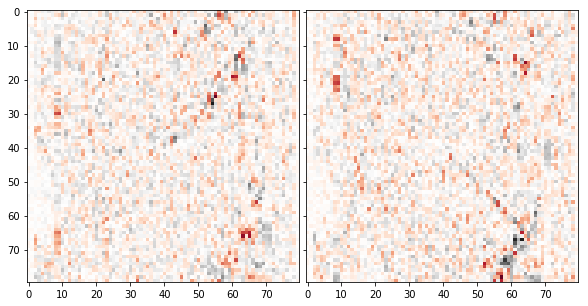

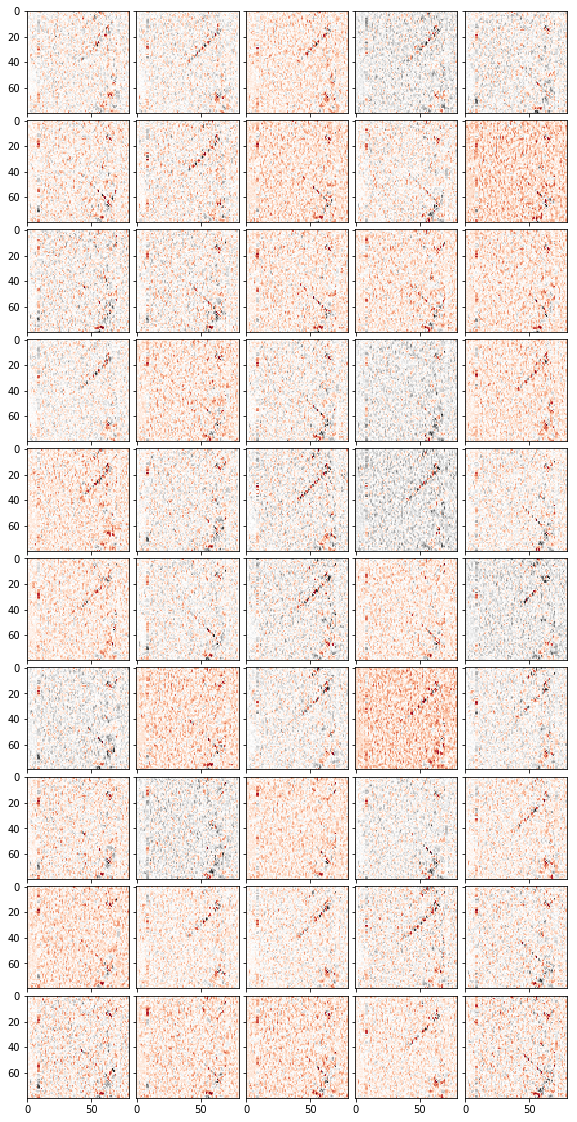

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid

model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (10., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = model['W1'][0,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = model['W1'][8,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 20.))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(50):
    # The AxesGrid object work as a list of axes.
    image = model['W1'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()